# Proyecto 1 - etapa 2
<h3>Natalia Ortega (sección 4), David Leon (sección 3) & Juan Camilo Mercado (sección 4)</h3>

## 0. Carga de librerías y datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn as sklearn
import numpy as np
import nltk
import random
import statistics
import string
import unicodedata

from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.probability import *
from nltk.tokenize import word_tokenize

from scipy import stats as st

from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report


from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay



C:\Users\CAMILO\AppData\Local\Temp\ipykernel_2580\3471827481.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


se descargan los módulos específicos de la librería nltk para poder procesar le texto de la mejor forma posible:

In [2]:
nltk.download('punkt');
nltk.download('stopwords');
nltk.download('wordnet');

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CAMILO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CAMILO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CAMILO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('./data/tipo2_entrenamiento_estudiantes.csv', sep=',', encoding = 'utf-8')

## 1. Entendimiento y preparación de datos

### Entendimiento

Con los datos de los actores de turismo leyendo el conjunto de datos correspondiente de reseñas de sitios turísticos, se procede a entender la estructura de los comentarios que estos nos presentan.

In [4]:
print(f">> Se puede observar que el df de entrenamiento contiene {df.shape[0]} reseñas")

>> Se puede observar que el df de entrenamiento contiene 7875 reseñas


Se observan que solo existen 2 columnas, una con la s¿reseña y otra con la calificación corrrespondiente, donde se identifica que no hay datos faltantes ni atípicos respecto al tipo de dato, pues la columna numérica peranece numérica.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  7875 non-null   object
 1   Class   7875 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 123.2+ KB


In [6]:
print(">> El df se ve de la siguiente forma:")
df.head()

>> El df se ve de la siguiente forma:


,Review,Class
0,Muy buena atención y aclaración de dudas por p...,5
1,Buen hotel si están obligados a estar cerca de...,3
2,"Es un lugar muy lindo para fotografías, visite...",5
3,Abusados con la factura de alimentos siempre s...,3
4,Tuvimos un par de personas en el grupo que rea...,3


Cada una de estas reseñas contiene una calificación de acuerdo al sentimiento que tuvo el turista al visitarlo, por lo que es importante ver las tendencias de calificaciones, y las tendencias de las reseñas.

Se observa que las reseñas varían en cantidad de palabras, donde hay palabras que se repiten y generan una moda, los cuales suelen ser palabras que no aportan valor al análisis (no son sustantivos, verbos o adjetivos). Se observa el uso de mayúsculas y minúsuculas para diferenciar entre diferentes tipos de palabras, per en este contexto no aporta al análisis.

In [7]:
textos = df.copy()
textos['Conteo'] = [len(x) for x in textos['Review']]
textos['Palabras únicas'] = [len(set(x)) for x in textos['Review']]
textos['Max. de palabra'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Review']]
textos['Min. de palabra'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Review']]
textos['Moda'] = [statistics.mode(i.split(' ')) for i in textos['Review']]

textos

,Review,Class,Conteo,Palabras únicas,Max. de palabra,Min. de palabra,Moda
0,Muy buena atención y aclaración de dudas por p...,5,252,28,20,0,
1,Buen hotel si están obligados a estar cerca de...,3,297,34,13,1,de
2,"Es un lugar muy lindo para fotografías, visite...",5,104,26,12,1,Es
3,Abusados con la factura de alimentos siempre s...,3,422,28,14,1,y
4,Tuvimos un par de personas en el grupo que rea...,3,419,35,14,1,el
...,...,...,...,...,...,...,...
7870,"Me parece buen sistema, agiliza el transporte,...",4,113,24,11,2,el
7871,"Fue una escapada de un día desde el complejo, ...",4,261,31,12,2,de
7872,La Plaza de la Revolución es un lugar emblemát...,3,777,43,14,1,de
7873,Es la segunda ocasión que me quedo en los cuar...,1,651,38,12,0,que


igualmente, se busca observar que las clases sean valores válidos y definidos (números enteros del 1 al 5). Además se busca observar su frecuencia para observar la cantidad de reseñas que tenemos como muestra de cada una de las clases correspondientes.

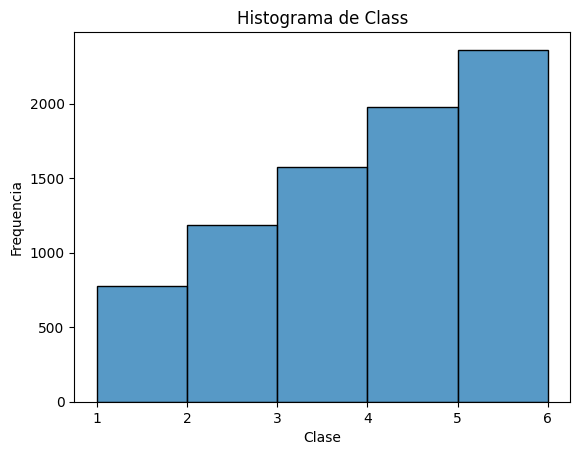

In [8]:
sns.histplot(data=textos, x='Class', bins=range(1, 7), kde=False)
plt.xlabel('Clase')
plt.ylabel('Frequencia')
plt.title('Histograma de Class')
plt.xticks(range(1, 7))
plt.show()

Se observa que hay mayor número de comentarios de clase 5, y va disminuyendo la cantidad con su categoría, por lo que se sabe que la mayor confiabilidad del entrenamiento se dará con la clase 5, así sucesivamente hasta la clase 1 que tendrá la menor confiabilidad al contar con la menor cantidad de datos para realizar el análisis.

Ahora bien, para darles significado, se muestran ejemplos de comentarios por clase para definir el significado de cada una.

In [9]:
pd.set_option('display.max_colwidth', None)

clases_muestra = df['Class'].unique()
comentarios_muestra = []
for clase in clases_muestra:
    comentario = df[df['Class'] == clase]['Review'].iloc[0]
    comentarios_muestra.append(comentario)
tabla_muestra = pd.DataFrame({'Clase': clases_muestra, 'Comentario': comentarios_muestra})
tabla_muestra.sort_values('Clase', inplace=True)

tabla_muestra


,Clase,Comentario
4,1,"Se equivocaron en la central de reservas y al llegar al hotel me cobraron más para poder alojarme Una habitación con 3 recamaras y me pusieron solo un huésped 🤦🏽‍♂️ No tienen sentido común, acabe pagando por las otras 5. O sea me engañaron 😡"
3,2,"Acabo de volver de Cuba. La primera semana en Tryp Habana libre y no puedo recomendar que a nadie. La primera imagen en el vestíbulo estaba bastante bien pero cuando salimos del ascensor en el piso, no pudimos evitar el olor a moho. Tras par de noche había una enorme fuga de agua en el baño y tuvimos que cambiar de habitación. La segunda habitación era tan fría que teníamos que llevar cordero grillada calcetines de lana y un suéter mientras duerme. Los recepcionistas eran todos antipático. El desayuno estaba bien, pero el piso 25 club nocturno terrible con banda ruidosa y mala. No bañados por ir a este hotel, que debe ser renovada completamente. Algo bueno? La vista ..."
1,3,"Buen hotel si están obligados a estar cerca del centro de convenciones, pero el restaurante necesita mejorar! Frío y café flojo - y - un montón de pan de personas que sirve unos uderstanding de bu lo que significa un servicio. En este barrio con tan pocas opciones - debería ser un hotel especial."
2,4,Un complejo enorme de fortificaciones frente al antiguo de La Habana. Visité en un día cuando el otro lado del castillo era trincadas con agua elevándose a 20 metros o más desde el mar.
0,5,"Muy buena atención y aclaración de dudas por parte de la señorita Verónica castillo, atenta y amable en cuestión laborable. Ideal para descansar muy buenas habitaciónes, limpieza, ordenadas. Buena comida de parte del restaurante,variedad en comidas"


Se observa que en este contexto los comentarios con clase 5 son aquellos de mayor positividad y gratitud, seguidos de la clase 4 que muestra positividad moderada pero notable. Los comentarios de clase 3 son aquellos que se muestran entre neutrales y buenos en su opinión,seguidos por la clase 2 que muestra tener comentarios negativos o levemente negativos, y finalmente, la clase 1 que muestra total desagrado con la experiencia.

Igualmente, se busca obtener las medidas de tendencia central para cada uno de los grupos de análisis de los comentarios, para observar el promedio de la longitud de los comentarios y las palabras únicas, qué tanto varían estas cantidades con la desviación estándar, cual es el máximo número de palabras únicas que existe y el mínimo. Esto será importante para observar cómo se puede comportar la lemantización futura de estas palabras.

In [10]:
textos.describe()

,Class,Conteo,Palabras únicas,Max. de palabra,Min. de palabra
count,7875.000000,7875.000000,7875.000000,7875.000000,7875.000000
mean,3.502603,408.050413,33.117714,13.145778,0.858413
std,1.320435,474.145795,7.896652,2.930502,0.515585
min,1.000000,9.000000,9.000000,4.000000,0.000000
25%,3.000000,196.000000,28.000000,11.000000,1.000000
50%,4.000000,269.000000,31.000000,13.000000,1.000000
75%,5.000000,488.000000,37.000000,14.000000,1.000000
max,5.000000,10403.000000,80.000000,76.000000,5.000000


Asimismo, se busca obsrvar un ejemplo de un comentario para ver cómo se distribuyen sus palabras y su frecuencia, igualmente para observar la influencia d caracteres como espacios, comas, tíldes u otros caracteres que puedan entorpecer el entendimiento del comentario para el algoritmo.

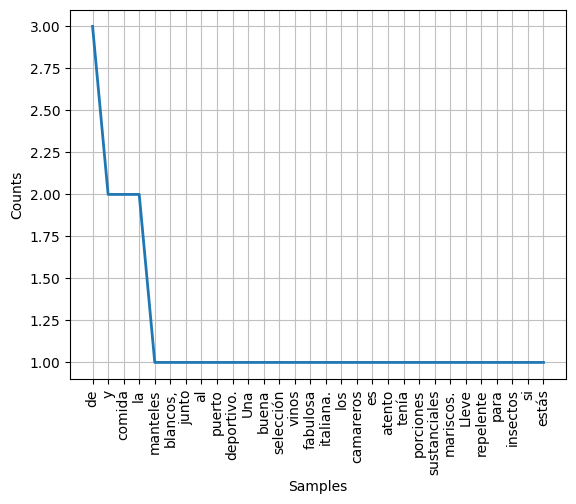

<Axes: xlabel='Samples', ylabel='Counts'>

In [11]:
fdist = FreqDist(df['Review'][random.randint(0, df.shape[0])].split(' '))
fdist.plot(30, cumulative = False)

Viendo que es evidente la influencia de los caracteres especiales en los comentarios se procede a hacer la limpieza de datos por lo que, como primer paso, se  hace la tokenización de los comentarios.

### Segmentación de palabras (tokenización)

La tokenización se realiza para convertir el texto en una forma que pueda ser procesada por algoritmos de ML. Al dividir el texto en tokens, se crea una representación estructurada que permite al algoritmo comprender y analizar el contenido del texto de manera más efectiva.

En este caso se hace tokenización basada en palabras. Este enfoque divide el texto en palabras individuales. Utiliza espacios en blanco y signos de puntuación como delimitadores para identificar las palabras.

In [12]:
def tokenize(data: pd.DataFrame):
    data['Words'] = data['Review'].apply(word_tokenize)
    return data

In [13]:
token_df = df.copy()
tokenize(token_df)
token_df.head()

,Review,Class,Words
0,"Muy buena atención y aclaración de dudas por parte de la señorita Verónica castillo, atenta y amable en cuestión laborable. Ideal para descansar muy buenas habitaciónes, limpieza, ordenadas. Buena comida de parte del restaurante,variedad en comidas",5,"[Muy, buena, atención, y, aclaración, de, dudas, por, parte, de, la, señorita, Verónica, castillo, ,, atenta, y, amable, en, cuestión, laborable, ., Ideal, para, descansar, muy, buenas, habitaciónes, ,, limpieza, ,, ordenadas, ., Buena, comida, de, parte, del, restaurante, ,, variedad, en, comidas]"
1,"Buen hotel si están obligados a estar cerca del centro de convenciones, pero el restaurante necesita mejorar! Frío y café flojo - y - un montón de pan de personas que sirve unos uderstanding de bu lo que significa un servicio. En este barrio con tan pocas opciones - debería ser un hotel especial.",3,"[Buen, hotel, si, están, obligados, a, estar, cerca, del, centro, de, convenciones, ,, pero, el, restaurante, necesita, mejorar, !, Frío, y, café, flojo, -, y, -, un, montón, de, pan, de, personas, que, sirve, unos, uderstanding, de, bu, lo, que, significa, un, servicio, ., En, este, barrio, con, tan, pocas, opciones, -, debería, ser, un, hotel, especial, .]"
2,"Es un lugar muy lindo para fotografías, visiten Selina, música en vivo, cerveza artesanal y buena comida",5,"[Es, un, lugar, muy, lindo, para, fotografías, ,, visiten, Selina, ,, música, en, vivo, ,, cerveza, artesanal, y, buena, comida]"
3,Abusados con la factura de alimentos siempre se echan la culpa unos a otros van y buscan el rfc que les proporcionaste por que independisan la base que ya tienen registrada en alimentos con la base del check in y ya pasaron 3 dias y aun nadade mi factura aunque hables de larga distancia y queden formalmente fe enviartela en un momento no es asi mañana otra vez voy a tener que hablar y para colmo ni el ticket me dieron.,3,"[Abusados, con, la, factura, de, alimentos, siempre, se, echan, la, culpa, unos, a, otros, van, y, buscan, el, rfc, que, les, proporcionaste, por, que, independisan, la, base, que, ya, tienen, registrada, en, alimentos, con, la, base, del, check, in, y, ya, pasaron, 3, dias, y, aun, nadade, mi, factura, aunque, hables, de, larga, distancia, y, queden, formalmente, fe, enviartela, en, un, momento, no, es, asi, mañana, otra, vez, voy, a, tener, que, hablar, y, para, colmo, ni, el, ticket, me, dieron, .]"
4,"Tuvimos un par de personas en el grupo que realmente queríamos comer cabrito, el resto de nosotros eran buenas con probarla. Servicio empezó realmente bien, hasta que llegamos a situar nuestros pedidos. Cuando le preguntamos acerca de cómo agregar o sustituir elementos el camarero casi...parecía molestarle y claro qué y cómo lo ve en el menú es la única opción. Aparte de eso, la comida y el ambiente donde genial!Más",3,"[Tuvimos, un, par, de, personas, en, el, grupo, que, realmente, queríamos, comer, cabrito, ,, el, resto, de, nosotros, eran, buenas, con, probarla, ., Servicio, empezó, realmente, bien, ,, hasta, que, llegamos, a, situar, nuestros, pedidos, ., Cuando, le, preguntamos, acerca, de, cómo, agregar, o, sustituir, elementos, el, camarero, casi, ..., parecía, molestarle, y, claro, qué, y, cómo, lo, ve, en, el, menú, es, la, única, opción, ., Aparte, de, eso, ,, la, comida, y, el, ambiente, donde, genial, !, Más]"


### Limpieza de datos (StopWords) y análisis lexicográfico

Como se observa, existen tokens que entorpecen el entendimiento de las palabras, como lo son los denominados stopwprds, los cuales son palabras comunes que se consideran irrelevantes para el análisis de texto debido a su alta frecuencia de aparición en un lenguaje determinado. Estas palabras, como "el", "la", "y", "a", "de", entre otras, no aportan información significativa para el análisis de texto y suelen ser eliminadas o ignoradas en tareas de procesamiento de lenguaje natural, por esto se hace el tratamiento respectivo para eliminarlas de los tokens con la clase TextProcessor, cyos objetos serán capaces que preprocesar los datos, pues, hará conversión en minúsculas, removerá caracteres especiales y signos de puntuación y finalmente hará la extracción de los lemas de las palabras para que lo importante sea su significado y no su forma gramatical.


In [14]:
class TextProcessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('spanish'))
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = SnowballStemmer('spanish')
        self.punctuation = string.punctuation

    def to_lowercase(self, texto):
        return [word.lower() for word in texto]

    def remove_punctuation(self, texto):
        return [word for word in texto if word not in self.punctuation]

    def remove_triple_punctuation(self, texto):
        return [word for word in texto if word != '...']

    def remove_stopwords(self, texto):
        return [word for word in texto if word not in self.stop_words]

    def lemmatize(self, texto):
        return [self.lemmatizer.lemmatize(word) for word in texto]

    def stem(self, texto):
        return [self.stemmer.stem(word) for word in texto]

    def remove_non_ascii(self, texto):
        return [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in texto]

    def preprocess(self, texto):
        texto = self.to_lowercase(texto)
        texto = self.remove_punctuation(texto)
        texto = self.remove_triple_punctuation(texto)
        texto = self.remove_stopwords(texto)
        texto = self.lemmatize(texto)
        texto = self.stem(texto)
        texto = self.remove_non_ascii(texto)
        return texto
    
def clean_process(data: pd.DataFrame):
    processor = TextProcessor()
    data['Stemmed words'] = [processor.preprocess(text) for text in data['Words']]
    return data

Ahora se hará la conversión respectiva con un objeto de la clase construida:

In [15]:
clean_process(token_df)
token_df.head()

,Review,Class,Words,Stemmed words
0,"Muy buena atención y aclaración de dudas por parte de la señorita Verónica castillo, atenta y amable en cuestión laborable. Ideal para descansar muy buenas habitaciónes, limpieza, ordenadas. Buena comida de parte del restaurante,variedad en comidas",5,"[Muy, buena, atención, y, aclaración, de, dudas, por, parte, de, la, señorita, Verónica, castillo, ,, atenta, y, amable, en, cuestión, laborable, ., Ideal, para, descansar, muy, buenas, habitaciónes, ,, limpieza, ,, ordenadas, ., Buena, comida, de, parte, del, restaurante, ,, variedad, en, comidas]","[buen, atencion, aclar, dud, part, senorit, veron, castill, atent, amabl, cuestion, labor, ideal, descans, buen, habitacion, limpiez, orden, buen, com, part, restaur, varied, com]"
1,"Buen hotel si están obligados a estar cerca del centro de convenciones, pero el restaurante necesita mejorar! Frío y café flojo - y - un montón de pan de personas que sirve unos uderstanding de bu lo que significa un servicio. En este barrio con tan pocas opciones - debería ser un hotel especial.",3,"[Buen, hotel, si, están, obligados, a, estar, cerca, del, centro, de, convenciones, ,, pero, el, restaurante, necesita, mejorar, !, Frío, y, café, flojo, -, y, -, un, montón, de, pan, de, personas, que, sirve, unos, uderstanding, de, bu, lo, que, significa, un, servicio, ., En, este, barrio, con, tan, pocas, opciones, -, debería, ser, un, hotel, especial, .]","[buen, hotel, si, oblig, cerc, centr, convencion, restaur, necesit, mejor, fri, caf, floj, monton, pan, person, sirv, uderstanding, bu, signif, servici, barri, tan, poc, opcion, deb, ser, hotel, especial]"
2,"Es un lugar muy lindo para fotografías, visiten Selina, música en vivo, cerveza artesanal y buena comida",5,"[Es, un, lugar, muy, lindo, para, fotografías, ,, visiten, Selina, ,, música, en, vivo, ,, cerveza, artesanal, y, buena, comida]","[lug, lind, fotograf, visit, selin, music, viv, cervez, artesanal, buen, com]"
3,Abusados con la factura de alimentos siempre se echan la culpa unos a otros van y buscan el rfc que les proporcionaste por que independisan la base que ya tienen registrada en alimentos con la base del check in y ya pasaron 3 dias y aun nadade mi factura aunque hables de larga distancia y queden formalmente fe enviartela en un momento no es asi mañana otra vez voy a tener que hablar y para colmo ni el ticket me dieron.,3,"[Abusados, con, la, factura, de, alimentos, siempre, se, echan, la, culpa, unos, a, otros, van, y, buscan, el, rfc, que, les, proporcionaste, por, que, independisan, la, base, que, ya, tienen, registrada, en, alimentos, con, la, base, del, check, in, y, ya, pasaron, 3, dias, y, aun, nadade, mi, factura, aunque, hables, de, larga, distancia, y, queden, formalmente, fe, enviartela, en, un, momento, no, es, asi, mañana, otra, vez, voy, a, tener, que, hablar, y, para, colmo, ni, el, ticket, me, dieron, .]","[abus, factur, aliment, siempr, echan, culp, van, busc, rfc, proporcion, independis, bas, registr, aliment, bas, check, in, pas, 3, dia, aun, nadad, factur, aunqu, habl, larg, distanci, qued, formal, fe, enviartel, moment, asi, manan, vez, voy, ten, habl, colm, ticket, dieron]"
4,"Tuvimos un par de personas en el grupo que realmente queríamos comer cabrito, el resto de nosotros eran buenas con probarla. Servicio empezó realmente bien, hasta que llegamos a situar nuestros pedidos. Cuando le preguntamos acerca de cómo agregar o sustituir elementos el camarero casi...parecía molestarle y claro qué y cómo lo ve en el menú es la única opción. Aparte de eso, la comida y el ambiente donde genial!Más",3,"[Tuvimos, un, par, de, personas, en, el, grupo, que, realmente, queríamos, comer, cabrito, ,, el, resto, de, nosotros, eran, buenas, con, probarla, ., Servicio, empezó, realmente, bien, ,, hasta, que, llegamos, a, situar, nuestros, pedidos, ., Cuando, le, preguntamos, acerca, de, cómo, agregar, o, sustituir, elementos, el, camarero, casi, ..., parecía, molestarle, y, claro, qué, y, cóm

Ahora podemos observae la conversión d elas palabras y la frecuencia de estas, lo que se muestra en el siguiente ejemplo donde se observan los lemas limpios de caracteres especviales, mayúsculas, puntuación, entre otros.

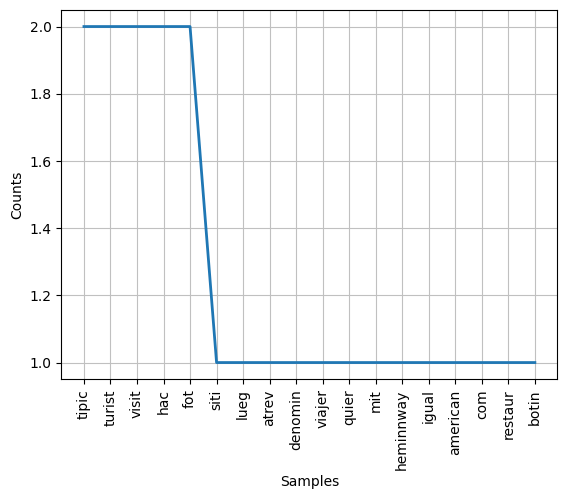

<Axes: xlabel='Samples', ylabel='Counts'>

In [16]:
fdist = FreqDist(token_df['Stemmed words'][random.randint(0, df.shape[0])])
fdist.plot(30, cumulative = False)

### Vectorización, modelado y evaluación

Como primer paso para el modelado, es necesario vectorizar las reseñas para que el computador pueda tener un correcto entendimiento de estas, por lo que un primer paso es juntar los lemas enlistados en oraciones representantes de sus respectivas reseñas. Igualmente, al juntar estas oraciones se hace la división de datos de entrenaiento y test. Los datos de entrenamiento se parten a su vez en modelado y validación.

In [17]:
token_df['Text'] = [' '.join(text) for text in token_df['Stemmed words']]

X = token_df['Text']
Y = token_df['Class']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=777)
X_modeling, X_validation, Y_modeling, Y_validation = train_test_split(X_train, Y_train, test_size=0.2, random_state=777)

Ahora bien, para vectorizar se tendrán en cuenta 3 formas de vectorización, que, teniendo en cuenta las ventajas y desvantajas de cada una, se conoce que no hay un mejor vectorizador para todos los casos. La elección del vectorizador depende de la complejidad de las reseñas, por lo que se construye, primero, un vectorizador de forma 'word2vec' y posteriormente, se hace una funación que evalúe la calidad del resultado de modelado y validación para los vectorizadores 'word2vec', 'Count' y 'Tfidf', el cual retorna el mejor vectorizador observando los resultados obtenidos.

In [18]:
def word2vec(model):
    sentences = [text.split() for text in X_train]
    word2vec_vectorizer = Word2Vec(sentences, vector_size=3, window=2, min_count=1)
    X_list_train = []
    for text in sentences:
        vector = np.zeros(3) 
        for word in text:
            if word in word2vec_vectorizer.wv:
                vector += word2vec_vectorizer.wv[word]
        X_list_train.append(vector)
    X_temp_train = np.array(X_list_train)
    X_temp_modeling, X_temp_validation, Y_temp_modeling, Y_temp_validation = train_test_split(X_temp_train, Y_train, test_size=0.2, random_state=777)
    model.fit(X_temp_modeling, Y_temp_modeling)
    Y_temp_pred_validation = model.predict(X_temp_validation)
    score = f1_score(Y_temp_validation, Y_temp_pred_validation, average='micro')
    return word2vec_vectorizer, score, model


In [19]:
def best_vectorizer(model):
    best_vectorizer = None
    best_score = 0
    for vectorizer in ['CountVectorizer', 'TfidfVectorizer']:
        if vectorizer == 'CountVectorizer':
            vectorizer = CountVectorizer()
        else:
            vectorizer = TfidfVectorizer()
        X_modeling_transformed = vectorizer.fit_transform(X_modeling)
        model.fit(X_modeling_transformed, Y_modeling)
        X_validation_transformed = vectorizer.transform(X_validation)
        Y_pred_validation = model.predict(X_validation_transformed)
        score = f1_score(Y_validation, Y_pred_validation, average='micro')
        if score > best_score:
            best_score = score
            best_vectorizer = vectorizer
    try:
        word2vec_vectorizer, word2vec_score, word2vec_model = word2vec(model)
        if word2vec_score > best_score:
            best_score = word2vec_score
            best_vectorizer = word2vec_vectorizer
            model = word2vec_model
    except:
        print("(!) No se pudo realizar word2vec por el motivo mostrado")
    print(f">> El mejor vectorizador es {best_vectorizer} con un score f1 de {best_score}")
    return best_vectorizer, model

Ahora, se procede a hacer el modelado por medio de tres algoritmos para observar la mejor alternativa.

#### Modelado con 'SVC'

El SVC puede ser una opción interesante ya que, es capaz de manejar grandes cantidades de información, como las reseñas de turistas, y puede trabajar con diferentes tipos de datos, lo que lo hace bastante opcionado para este tipo de análisis de textos. Es conocido por dar buenos resultados incluso con conjuntos de datos relativamente pequeños y puede manejar bien el ruido y las características irrelevantes.

En primer lugar, se inicializa un modelo SVC y luego se busca el mejor método para convertir texto en datos numéricos mediante la función best_vectorizer. Después de llamar a esta función, se asignan el mejor vectorizador y el modelo SVC actualizado, lo que asegura el uso del enfoque más efectivo para analizar las reseñas turísticas.

In [21]:
model = SVC(kernel='linear', probability=False )
vectorizer, model = best_vectorizer(model)

>> El mejor vectorizador es TfidfVectorizer() con un score f1 de 0.4785714285714286


Se procede a inicializar y ajustar el vectorizador TF-IDF (teniendo en cuenta la información obtenida sobre el mejor vectorizador); este proceso asigna valores numéricos a las palabras en función de su importancia en el texto. Esto ayuda a los modelos a entender qué palabras son importantes para predecir resultados.

In [22]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Se procede a entrenar el modelo SVC con los datos de entrenamiento.

In [23]:
model.fit(X_train_tfidf, Y_train)

SVC(kernel='linear')

Se realizan predicciones sobre los datos de prueba utilizando el modelo SVC entrenado. Estas predicciones serán usadas mas adelante en el análisis cuantitativo. 

In [24]:
predicciones = model.predict(X_test_tfidf)

#### Validación cuantitativa con 'SVC'

Para la validación, se imprime un informe de clasificación que muestra la precisión, el recall y la puntuación F1 del modelo en los datos de prueba, comparando las etiquetas verdaderas (Y_test) con las predicciones realizadas por el modelo.

In [25]:
print(classification_report(Y_test, predicciones))

              precision    recall  f1-score   support

           1       0.50      0.39      0.44       138
           2       0.44      0.37      0.40       244
           3       0.40      0.43      0.41       314
           4       0.47      0.43      0.45       424
           5       0.60      0.70      0.64       455

    accuracy                           0.50      1575
   macro avg       0.48      0.46      0.47      1575
weighted avg       0.49      0.50      0.49      1575



Una vez poseemos la información sobre el rendimiento del modelo, procedemos a describir lo encontrado en cada categoría:

La precisión (que representa el porcentaje de verdaderos positivos respecto a todos los positivos), muestra variaciones según la clase, la mas alta se ve en la clase 1 con un 60%, mientras que la más baja es para la clase 3 con un 40%. El recall, por otro lado, es el porcentaje de verdaderos positivos respecto a todos los ejemplos que son realmente de esa clase; la clase 5 obtuvo el valor más alto (70%), indicando que el modelo identifica bien la mayoría de estos ejemplos. El F1-score, es medida que proporciona un balance entre precisión y recall, encontramos que es más alto para la clase 5 (64%); esto nos indica un buen equilibrio entre ambas métricas. 

Por otra parte, con respecto al accuracy, que muestra el porcentaje de predicciones correctas en el conjunto de prueba, el cual es del 50% en este caso, se indica que el modelo clasifica correctamente la mitad de las muestras del conjunto de prueba.

Procedemos con calcular el F1 score y se realiza el entrenamiento con el set completo de entrenamiento::

In [26]:
X_train_transformed = vectorizer.fit_transform(X_train)
model.fit(X_train_transformed, Y_train)
X_test_transformed = vectorizer.transform(X_test)
Y_pred_test = model.predict(X_test_transformed)
score = f1_score(Y_test, Y_pred_test, average='micro')
print(f">> El puntaje f1 de test es {score}")

>> El puntaje f1 de test es 0.49523809523809526


Ya que el puntaje F1 más alto indica un mejor rendimiento del modelo en los datos de prueba, con los resultados obtenidos de 0.49 aproximadamente, se dice que el modelo tiene un rendimiento moderado en la clasificación de los datos de prueba.

Obtenemos los puntajes overall del modelo.

In [27]:
print("Recall: {}".format(recall_score(Y_test, Y_pred_test, average='micro')))
print("Precisión: {}".format(precision_score(Y_test, Y_pred_test, average='micro')))
print("Puntuación F1: {}".format(f1_score(Y_test, Y_pred_test, average='micro')))

Recall: 0.49523809523809526
Precisión: 0.49523809523809526
Puntuación F1: 0.49523809523809526


Realizamos un plot para verificar la manera en la que se clasificaron y verificar la efectividad relativa.

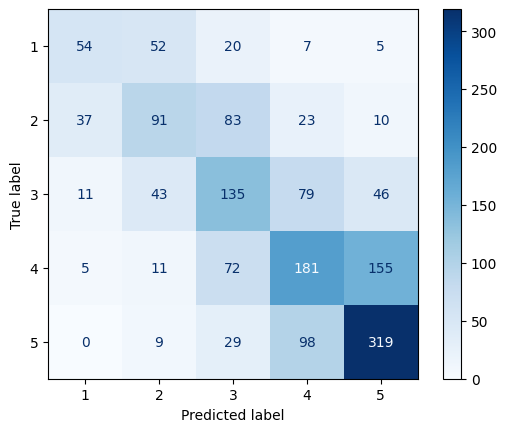

In [28]:
cm = confusion_matrix(Y_test, Y_pred_test)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

Observamos que, por ejemplo para el caso donde se predijo 1 y la verdadera etiqueta es 5 es un error de clasificación que no se dió; lo cual es una buena señal. Podemos observar que a medida que las etiquetas se van acercando a su valor real, se empiezan a ver más errores. en general podemos decir que es muy probable que el modelo clasifique bien con la etiqueta 5, sin embargo en etiquetas como la 2, es muy cercano el valor para las predicciones 2 y 3 lo que nos indica que en esos apartados puede estar teniendo dificultades. Finalmente, se ven casos como el de la etiqueta real 1, donde casi iguala la mas prediccha con la clase 2, lo cual nos muestra una vez más en los apartados que se están teniendo dificultades y dónde se encuentran las oportunidades de mejora.

Realizamos un análisis para los extremos de las etiquetas (1 vs 5) con el fin de verificar la naturaleza de los errores o si son producto de una mala clasificación inicial.

In [29]:
falsos_negativos = (Y_test == 1) & (Y_pred_test == 5)

muestra_falso_negativo = X_test[falsos_negativos].sample(1).values[0]
fila_coincidente = token_df.loc[token_df['Text'] == muestra_falso_negativo]
resenia_falso_negativo = fila_coincidente['Review'].values[0]
print(resenia_falso_negativo)

gran caminata, fantástica excursión pero tenía mi teléfono me robaron de la bolsa en el camino a casa (era poner sábana del coche junto con todos los demás (s) una pena, ya que de lo contrario la compañía era bueno.así que mantén objetos valiosos en persona su cuando se viaja a la selva


Se puede observar que efectivamente es una reseña negativa por lo que se observa una dificultad que presenta el modelo. Sin embargo en esta categoría los errores relativos fueron bajos. 

Invertimos el caso (4 vs 1). No se hizo 5 vs 1 porque como se mencionó previamente, es un error que no se dió por lo que lo hacemos con 4.

In [30]:
falsos_positivos = (Y_test == 4) & (Y_pred_test == 1)

muestra_falso_positivo = X_test[falsos_positivos].sample(1).values[0]
fila_coincidente = token_df.loc[token_df['Text'] == muestra_falso_positivo]
resenia_falso_positivo = fila_coincidente['Review'].values[0]
print(resenia_falso_positivo)

Estuve en este hotel 4 dias y fue una experiencia muy bonita. El hotel limpio y buen precio por noche.  Algunas cosas que no me gustaron fue que el servicio al cliente no es lo mejor. Una vez fui a front desk a preguntad si sabian de una forma para yo agarrar servicio de llamadas en mexico ya que yo venia de EU y el muchacho jamas me volteo a ver los ojos no despego la mirada de la compu y solo contesto muy seco "Nose" otro dia pedi unas tijeras y no contestaron nada y de vuelta no me vieron alos ojos pero solo me pasaron las tijeras sin decir nada. La piscina pense que era la que estaba afuera y era piscina adwntro muy chica. Pero todo lo demas muy bonito.


En este caso la reseña es negativa y se confirma lo que se vió en el Plot sobre la dificultad que se tiene en el modelo en la etiqueta 4, en la cual la mayoría de muestras están mal clasificadas.

Validamos un comentario neutro clasificado neutro para confirmar el rendimiento.

In [31]:
verdaderos_positivos = (Y_test == 3) & (Y_pred_test == 3)

muestra_verdadero_positivo = X_test[verdaderos_positivos].sample(1).values[0]
fila_coincidente = token_df.loc[token_df['Text'] == muestra_verdadero_positivo]
resenia_verdadero_positivo = fila_coincidente['Review'].values[0]
print(resenia_verdadero_positivo)

instalaciones muy acordes y la limpieza muy buena el servicio muy deficiente y muchos problemas en conexión de Internet necesitan mejorar esa parte, y que el personal demuestren una mejor actitud y den una respuesta mas rápida a los problemas


Podemos observar que este comentario resalta aspectos positivos y negativos. Podríamos decir entonces que según el contexto y lo que menciona el usuario, es un caso de éxito para el modelo, pues fue identificado correctamente.

Revisamos las palabras más usadas por cada clase del modelo:

In [32]:
most_common_words = {}

for class_label in set(Y_pred_test):
    filtered_text = X_test[Y_pred_test == class_label]
    concatenated_text = ' '.join(filtered_text)
    words = nltk.word_tokenize(concatenated_text)
    fdist = FreqDist(words)
    sorted_words = sorted(fdist.items(), key=lambda x: x[1], reverse=True)
    
    most_common_words[class_label] = sorted_words[0][0] + ", " + sorted_words[1][0] + ", " + sorted_words[2][0] + ", " + sorted_words[3][0] + ", " + sorted_words[5][0]

for class_label, word in most_common_words.items():
    print(f"Clase {class_label}: Palabras más repetidas: {word}")
    

Clase 1: Palabras más repetidas: hotel, habit, lleg, mal, com
Clase 2: Palabras más repetidas: habit, hotel, com, mal, lug
Clase 3: Palabras más repetidas: buen, hotel, com, habit, bien
Clase 4: Palabras más repetidas: buen, hotel, lug, com, visit
Clase 5: Palabras más repetidas: com, lug, buen, excelent, visit


Podemos observar que palabras como 'excelent' o 'buen', son utiles en el manejo de la clasificación para la clase mas exitosa del modelo (la clase 5). Es importante mencionar también que para las demás categorías, puede que haya dificultad en la clasificación y es probable que esto se vea por la repetición de palabras que no aportan un contexto positivo o negativo, como lo son 'Hotel' y 'Habit'. También se puede observar que entre la categoria 3 y 4 hay varias palabras repetidas, por lo que es posible que a esto se pueda atribuir parte de las dificultades que esta teniendo el modelo en la diferenciación entre estas dos categorias.

Procedemos a imprimir el reporte de clasificación final.

In [33]:
report = classification_report(Y_test, Y_pred_test)
print(report)

              precision    recall  f1-score   support

           1       0.50      0.39      0.44       138
           2       0.44      0.37      0.40       244
           3       0.40      0.43      0.41       314
           4       0.47      0.43      0.45       424
           5       0.60      0.70      0.64       455

    accuracy                           0.50      1575
   macro avg       0.48      0.46      0.47      1575
weighted avg       0.49      0.50      0.49      1575



Decimos entonces que, el modelo muestra un desempeño moderado en la clasificación, con métricas que oscilan entre 0.4 y 0.64, lo que indica cierto margen de mejora en la capacidad de clasificación.

Finalmente, se decide guardar el modelo para su posterior uso. 

In [34]:
SVC_model = model
SVC_vectorizer = vectorizer

## Resultados

Al finalizar la construcción y estudio de los modelos, teniendo en cuenta el mayor puntaje de f1, junto a la cantidad de aciertos cercanos en clases aledañas a la clase real y restándo prestigio por colocar reseñas en clases equivocadas, el mejor modelo es el construido con el clasificador SVC, por lo que se usa como modelo predictor final.

In [35]:
model = SVC_model
vectorizer = SVC_vectorizer

### Creación de un PipeLine

Para facilidad y legibilidad se hace una función capaz de vectorizar, dar un resultado en formato para predecir y limpiar aquellas columnas que originalmente no se encontraban en el formato de los dadtos proporcionados.

In [37]:
def clean_vectorize(data: pd.DataFrame, vectorizer):
    data['Text'] = [' '.join(text) for text in data['Stemmed words']]
    X_etiquetado = vectorizer.transform(data['Text'])
    data.drop(['Text', 'Words', 'Stemmed words'], axis=1, inplace=True)
    return X_etiquetado

In [43]:
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

In [50]:
preproccessor = Pipeline(
    [
        ("tokenize", FunctionTransformer(
            tokenize, validate=False)),
        ("clean", FunctionTransformer(
            clean_process, validate=False)),
        ("vectorize", FunctionTransformer(clean_vectorize, validate=False, kw_args={"vectorizer": vectorizer})),
    ]
)

In [51]:
pipeline = Pipeline(
    [
        ("preproccessor", preproccessor),
        ("model", SVC(kernel='linear', probability=False))
    ]
)  

In [52]:
X = df
Y = df['Class']

pipeline.fit(X, Y)

Pipeline(steps=[('preproccessor',
                 Pipeline(steps=[('tokenize',
                                  FunctionTransformer(func=<function tokenize at 0x00000175A9A1EE80>)),
                                 ('clean',
                                  FunctionTransformer(func=<function clean_process at 0x00000175D173BBA0>)),
                                 ('vectorize',
                                  FunctionTransformer(func=<function clean_vectorize at 0x00000175E0625620>,
                                                      kw_args={'vectorizer': TfidfVectorizer()}))])),
                ('model', SVC(kernel='linear'))])

In [53]:
pipeline_file = "result/model.joblib"

dump(pipeline, pipeline_file)
pipeline_loaded = load(pipeline_file)

### Etiquetado de los datos propocionados

Para realizar el etiquetado de los datos con el modelo construido y el vectorizador usado, primero se lee el archivo de datos sin etiquetar.

In [54]:
df_etiquetado = pd.read_csv('./data/particion_prueba_estudiantes.csv', sep=',', encoding = 'utf-8')

Se hacen los pasos de tokenización, limpieza de datos y la transformación en vectores para poder predecir la clase de cada una de las reseñas dadas.

Se hace la predicción de las clases a las que pertenecen los comentarios, la cual se ve de la siguiente forma:

In [55]:
df_etiquetado['Class'] = pipeline_loaded.predict(df_etiquetado)
df_etiquetado.head()

,Review,Class
0,"La primera noche nos encontramos en la habitación con un nido (5) de cucarachas muertas y la alfombra muy sucia...que por cierto nunca limpiaron hasta que reclamamos. La cena de fin de año fue un bufete que acabó en un tremendo desorden por el excesivo número de mesas vendidas, no se podía caminar para ir a servirte la comida, para luego encontrarte con bandejas vacías, mi esposa y yo y otra pareja ""NO CENAMOS"" porque nos encontramos con puras bandejas vacías!!...pagamos $2800 pesos por por pareja por nada!!! El servicio del restaurante pesimo, pesimo,pesimo....se tardaron muchísimo tiempo en atendernos, nos trajeron el desayuno en partes, nunca nos dieron el café que pedimos desde que llegamos....un pésimo servicio El frigobar vacío y después de reclamar lo surtieron pero_x0085_",1
1,"A una calle de catedral con platillos tradicionales, tipo Gourmet, de buen sabor y calidad.\nSi bien ofrecen una carta con los platillos más representativos de cada temporada como mole de caderas, poblano, chinicuiles, chiles en nogada, escamoles y cemitas; son principalmente para degustación, no...Más",5
2,Porciones muy miserables\nAgua con sabor a cloro \nMuy distraídos los meseros \nNo llena las expectativas\nHay mejores opciones,2
3,"Cartagena encanta. De todas las ciudades coloniales que hemos visitado es la más linda y mejor conservada. Recomiendo recorrerla tanto de día como de noche ya que son visiones distintas que vale la pena vivir. Llena de vida, tiendas, restaurantes, colorida, vibrante, calles y rincones que en cada momento guardan una sorpresa. Mi calificación habría sido excelente sino fuera por algunos detalles que deberían mejorar. Lamentablemente falta preocupación por la limpieza de las calles (problema que se repite en el resto de la ciudad) y un mejoramiento en los alcantarillados de las aguas servidas. Además por la estrechez de las calles deberían habilitar vías exclusivas para peatones.",5
4,"Ibamos con mucha ilusion de disfrutar el espectaculo de luz y sonido pero la verdad nos decepcionó,te ubican en una esquina a la entrada de las ruinas,y no al centro por lo que no puedes apreciar casi nada,las personas se paran a tomar fotografias debido a que no se alcanza a ver nada si estas sentado,al inicio y al final del espectaculo no dejan prendidas las luces para que puedas tomar fotografias, al contrario queda todo en obscuridad y las personas de la tercera edad tiene problemas para salir pues no iluminan ni el camino para salida, deberian poner aunque sea unas antorchas para iluminar,la verdad no lo recomiendo es una pena que una maravilla como lo es chichen itza tenga un espectaculo tan carente .",3


Igualmente se observa un ejemplo de comentario por cada una de las clases para validar el significado de estas y observar si el clasificador lo está haciendo de forma correcta.

In [56]:
clases_muestra = df_etiquetado['Class'].unique()
comentarios_muestra = []
for clase in clases_muestra:
    comentario = df_etiquetado[df_etiquetado['Class'] == clase]['Review'].iloc[1]
    comentarios_muestra.append(comentario)
tabla_muestra = pd.DataFrame({'Clase': clases_muestra, 'Comentario': comentarios_muestra})
tabla_muestra.sort_values('Clase', inplace=True)

tabla_muestra

,Clase,Comentario
0,1,"el sábado 12 de 11 del 2016.\ndesde que llegas el personal tiene el peor trato, no saben ingles. y al parecer tampoco español, 5 veces me preguntaron si mi reservacion era alli, como si despues de la 3 o 4 vez que me preguntaron mi respuesta seria diferente. por mas que les comprobe con boucher, intinerario y pago, no sabian en donde estaba mi reservacion, y decian que era hasta dentro de un mes, obvio fue error de ellos, pero nunca lo admitieron. Llegue a las 12 pm y no me encontraron habitacion hasta la 1pm, prometieron tenerla antes y no fue hasta despues de las 3 pm debido a la ocupacion que tenian, el hotel y los precios son de lujo pero el trato es de lo peor. tuve que hablar con 3 recepcionistas y nadie podia hacer nada. el gerente nunca llego, el supervisor nunca aparecio. y simplemente volteaban para otro lado cada ves que les poreguntaba por mi habitacion. practicamente 4 horas perdidas de mi dia, que no se pudo recuperar. en los restaurantes los meseros, sobretodo la mañana volteaban para otro lado al momento de pedir servcio, por mas desocupado que estaba el lugar no ofrecian ni una mesa, pero si ven a un estado unidense pasar hasta alfombra roja le tendian, no entiendo por que en este pasi en esta zona en especial hay tan mal trato a sus propios paisanos.\ntotalmente desagradable mi experiencia en este hotel. nada recomendable si eres de mexico.\nY NO HAY PLAYA COMO LO DICE EN INTERNET. TE TIENEN QUE TRASLADAR A EL OTRO HOTEL PARA ESO....."
2,2,"El personal de recepción es grosero y desinteresado. Pero las camareras, camareros y todo el personal era fabuloso. El hotel es precioso, pero las instalaciones y accesorios se caen a pedazos como es la Habana. Necesidades de un millón de dólares para poner justo. Mi limpieza Carlos era genial y me dejaron toallas modelos cada día. me hubiera gustado ver fotos de. Los coches clásicos, ver en fotos son un mito. Son realmente cubos de óxido. Cuba es el lugar más caro que he visitado. Ten cuidado. Todo cuesta!!!. Incluso lindas fotos si trad vestidas con gente en la calle a tomar fotos.estoy casi 60 y nunca volver de nuevo en mi vida porque le llevará 10 años y miles de millones de dólares para restaurar esta ciudad beautifil"
3,3,Me pareció muy simple y limitado en su oferta de productos. No se veía limpio.Lo que ahí se veía se encuentra en cualquier parte del país.
4,4,"Un hotel agradable con una buena ubicación para recorrer el Centro Histórico de Puebla sin tener que usar el vehículo. Le hace falta un servicio de café de cortesía y la alberca es muy pequeña, pero nos funcionó muy bien para conocer algunos museos, iglesias y sitios de interés sin tener que hacer uso del vehículo."
1,5,"Cartagena encanta. De todas las ciudades coloniales que hemos visitado es la más linda y mejor conservada. Recomiendo recorrerla tanto de día como de noche ya que son visiones distintas que vale la pena vivir. Llena de vida, tiendas, restaurantes, colorida, vibrante, calles y rincones que en cada momento guardan una sorpresa. Mi calificación habría sido excelente sino fuera por algunos detalles que deberían mejorar. Lamentablemente falta preocupación por la limpieza de las calles (problema que se repite en el resto de la ciudad) y un mejoramiento en los alcantarillados de las aguas servidas. Además por la estrechez de las calles deberían habilitar vías exclusivas para peatones."


Se observan problemas discutidos a lo largo del cuaderno, como lo son comentarios con una connotación pero que usa palabras de la connotación contraria. Aun así, por dicho elemento se sugiere la revisión de un operador como medida de asegfuramiento e incluso de alimentación continua del modelo si este se presa a seguir entrenándolo, ya que, una conclusión que se observa a lo largo del cuaderno es que a mayor número de datos de entrenamiento, mayores métricas de clasificación obtienen los modelos, por lo que el entrenamiento continuo del modelo reuslta útil para obtener los objetivos de negocio, asunto discutido en los resultados del documento anexo.

### Exportación a la carpeta 'result'

Por último, se guarda el resultado de las reseñas eqtiquetadas en la carpeta 'result' para su revisión.

In [57]:
df_etiquetado.to_csv('./result/particion_etiquetado.csv', sep=';', index=False)